In [1]:
import mysg
from astropy.table import Table
from astropy import units as u, constants
import pylab as pl
import requests

In [2]:
atmo_model = mysg.atmosphere.interp_atmos(2500)
phx4000 = Table(mysg.atmosphere.interp_atmos(4000))
phx4000['nu'].unit = u.Hz
phx4000['fnu'].unit = u.erg/u.s/u.cm**2/u.Hz

In [3]:
xarr = np.linspace(1, 28, 15000)*u.um

In [4]:
def atmo_model(temperature, xarr=np.linspace(1, 28, 15000)*u.um):
    mod = Table(mysg.atmosphere.interp_atmos(temperature))
    mod['nu'].unit = u.Hz    
    mod['fnu'].unit = u.erg/u.s/u.cm**2/u.Hz
    inds = np.argsort(mod['nu'])
    xarrhz = xarr.to(u.Hz, u.spectral())
    mod = Table({'fnu': np.interp(xarrhz, mod['nu'].quantity[inds], mod['fnu'].quantity[inds]),
                 'nu': xarrhz},
                meta={'temperature': temperature})
    
    return mod

In [5]:
phx4000 = atmo_model(4000)

In [6]:
# "https://raw.githubusercontent.com/willastro/ifw_miri_gto_pstars/main/nk/co2-a-Gerakines2020.txt",
molecule_data = {'ch3oh':
                 {'url': 'https://raw.githubusercontent.com/willastro/ifw_miri_gto_pstars/main/nk/ch3oh-a-Gerakines2020.txt',
                  'molwt': (12+4+16)*u.Da,},
                'co2':
                 {'url': 'https://raw.githubusercontent.com/willastro/ifw_miri_gto_pstars/main/nk/co2-a-Gerakines2020.txt',
                  'molwt': (12+2*16)*u.Da,},
                'ch4':
                 {'url': 'https://raw.githubusercontent.com/willastro/ifw_miri_gto_pstars/main/nk/ch4-a-Gerakines2020.txt',
                  'molwt': (12+4)*u.Da,},
                'co':
                 {'url': 'https://raw.githubusercontent.com/willastro/ifw_miri_gto_pstars/main/nk/co-a-Palumbo2006.txt',
                  'molwt': (12+16)*u.Da,},
                'h2o':
                 {'url': 'https://raw.githubusercontent.com/willastro/ifw_miri_gto_pstars/main/nk/h2o-a-Hudgins1993.txt',
                  'molwt': (16+2)*u.Da,},
                'h2o_b':
                 {'url': 'https://raw.githubusercontent.com/willastro/ifw_miri_gto_pstars/main/nk/h2o_Rocha.txt',
                  'molwt': (16+2)*u.Da,},
                'nh3':
                 {'url': 'https://raw.githubusercontent.com/willastro/ifw_miri_gto_pstars/main/nk/nh3_Roser_2021.txt',
                  'molwt': (14+3)*u.Da,
                  'density': 0.8*u.g/u.cm**3, # Satorre+2013 via Roser+2021 
                 },
                }

In [7]:
def load_molecule(molname):
    url = molecule_data[molname]['url']
    consts = Table.read(url, format='ascii', data_start=13)
    if 'col1' in consts.colnames:
        consts['col1'].unit = u.um
        consts.rename_column('col1', 'Wavelength')
        consts.rename_column('col2', 'n')
        consts.rename_column('col3', 'k')
    elif 'WaveNum' in consts.colnames:
        consts['Wavelength'] = consts['WaveNum'].quantity.to(u.um, u.spectral())
    if 'density' in molecule_data[molname]:
        consts.meta['density'] = molecule_data[molname]['density']
    else:
        lines = requests.get(url).text.split('\n')
        for line in lines:
            if not line.startswith("#"):
                break
        density = float(line.split()[1])*u.g/u.cm**3
        consts.meta['density'] = density
    return consts

In [8]:
nh3_consts = load_molecule('nh3')

In [9]:
co2_consts = load_molecule('co2')

### Ice Shapes
S4.4 of Gerakines & Hudson 2020 (https://iopscience.iop.org/article/10.3847/1538-4357/abad39) gives "IR absorption coefficient α(ν̃) (in cm−1)":
$$\alpha(\tilde{\nu}) = 4 \pi \tilde{\nu} k(\tilde{\nu})$$
and the band strength A (in cm molecule−1):
$$A = \frac{1}{\rho_N} \int_{band} \alpha(\tilde{\nu})d \tilde{\nu}$$

## TODO

$$A N = \int \tau_\nu d\nu$$

$$\frac{d}{d\nu} A N = \frac{d}{d\nu}\int \tau_\nu d\nu$$

$$N \frac{d}{d\nu} A = \tau_\nu $$

$$N \frac{\alpha_\nu}{\rho_N} = \tau_\nu $$

$$\tau_\nu = N \frac{\alpha_\nu}{\rho_N} = N \frac{4 \pi \tilde{\nu} k}{\rho_N}$$

In [10]:
def absorbed_spectrum2(ice_column,
                       ice_model_table,
                       spectrum=phx4000['fnu'],
                       xarr=u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()),
                       molecular_weight=44*u.Da,
                       return_tau=False):
    xarr_icm = xarr.to(u.cm**-1, u.spectral())
    dx_icm = np.abs(xarr_icm[1]-xarr_icm[0])
    inds = np.argsort(ice_model_table['Wavelength'].quantity)
    kay = np.interp(xarr.to(u.um),
                    ice_model_table['Wavelength'].quantity[inds],
                    ice_model_table['k'][inds])
    tau = (kay * xarr_icm * 4 * np.pi * ice_column / (ice_model_table.meta['density'] / molecular_weight)).decompose()
    if return_tau:
        return tau

    absorbed_spectrum = ((np.exp(-tau)) * spectrum)
    return absorbed_spectrum

(2.0, 25.0)

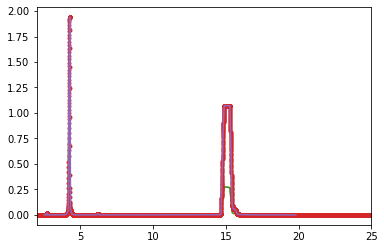

In [11]:
pl.plot(co2_consts['Wavelength'], co2_consts['k'])
xarr = u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral())
ice_column = 5e17*u.cm**-2
molecular_weight=44*u.Da

pl.plot(xarr,
        absorbed_spectrum2(ice_column, co2_consts, molecular_weight=molecular_weight, return_tau=True,
                                                     xarr=xarr))

# DEBUG
ice_model_table = co2_consts
xarr_icm = xarr.to(u.cm**-1, u.spectral())
dx_icm = np.abs(xarr_icm[1]-xarr_icm[0])
inds = np.argsort(ice_model_table['Wavelength'].quantity)
kay = np.interp(xarr.to(u.um),
                ice_model_table['Wavelength'].quantity[inds],
                ice_model_table['k'][inds])
tau = (kay * xarr_icm * 4 * np.pi * ice_column / (ice_model_table.meta['density'] / molecular_weight)).decompose()
pl.plot(xarr, tau)
pl.plot(xarr, kay, '.')
pl.plot(ice_model_table['Wavelength'].quantity[inds],
                ice_model_table['k'][inds])

pl.xlim(2,25)

(1.0, 25)

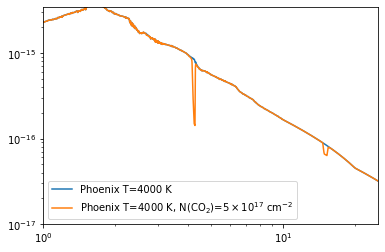

In [12]:
pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()), phx4000['fnu'], label="Phoenix T=4000 K")
pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()),
          absorbed_spectrum2(5e17*u.cm**-2, co2_consts, molecular_weight=(12+16*2)*u.Da),
          label="Phoenix T=4000 K, N(CO$_2$)=$5\\times10^{17}$ cm$^{-2}$")

pl.legend()
pl.ylim(1e-17, 3.5e-15)
pl.xlim(1.0, 25)

(1.0, 25)

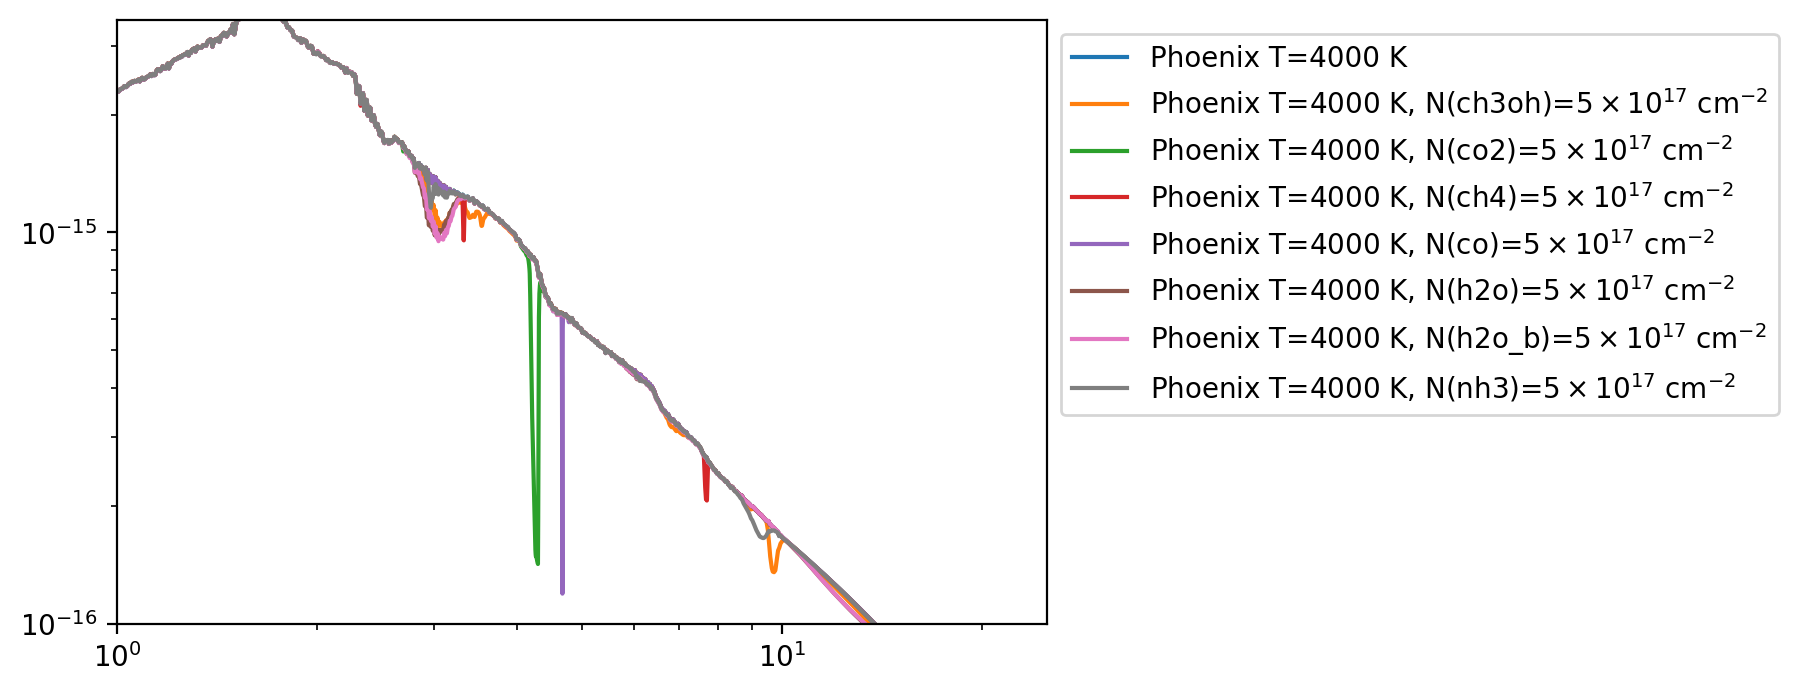

In [13]:
pl.figure(dpi=200)
pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()), phx4000['fnu'], label="Phoenix T=4000 K")

for molecule, md in molecule_data.items():
    #print(molecule, md)
    consts = load_molecule(molecule)
    spec = absorbed_spectrum2(5e17*u.cm**-2, consts, molecular_weight=md['molwt'])
    pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()),
              spec,
              label=f"Phoenix T=4000 K, N({molecule})=$5\\times10^{{17}}$ cm$^{{-2}}$")

pl.legend(bbox_to_anchor=[1.0, 1.0])
pl.ylim(1e-16, 3.5e-15)
pl.xlim(1.0, 25)

In [14]:
def isscalar(x):
    try:
        len(x)
        return False
    except Exception:
        return True

def absorbed_spectrum(ice_column, center, width, ice_bandstrength,
                      spectrum=phx4000['fnu'],
                      xarr=u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral())):
    tau = np.zeros(xarr.size)
    
    cens, wids, strengths = center, width, ice_bandstrength
    
    if not isscalar(center):
        for center, width, ice_bandstrength in zip(cens, wids, strengths):
            wid_icm = (width / center) * center.to(u.cm**-1, u.spectral())
            line_profile = 1/((2*np.pi)**0.5 * wid_icm) * np.exp(-(xarr-center)**2/(2*width**2))
            
            assert line_profile.unit.is_equivalent(u.cm)
            assert ice_bandstrength.unit.is_equivalent(u.cm)
            assert ice_column.unit.is_equivalent(u.cm**-2)
            
            tau = tau + (ice_column * ice_bandstrength * line_profile).decompose()
            assert tau.unit is u.dimensionless_unscaled
    else:
        wid_icm = (width / center) * center.to(u.cm**-1, u.spectral())
        line_profile = 1/((2*np.pi)**0.5 * wid_icm) * np.exp(-(xarr-center)**2/(2*width**2))

        # normalize the line profile: tau is peak tau, not integral tau.
        # nope line_profile = line_profile / line_profile.max()        
        tau = tau + (ice_column * ice_bandstrength * line_profile).decompose()
        assert tau.unit is u.dimensionless_unscaled

    absorbed_spectrum = ((np.exp(-tau)) * spectrum)
    return absorbed_spectrum

In [15]:
# apolar in CO2, apolar pure CO, polar methanol ice
co_ice_wls_icm = ([2143.7, 2139.9, 2136.5] * u.cm**-1)
co_ice_centers = co_ice_wls = co_ice_wls_icm.to(u.um, u.spectral())
co_ice_widths = (([3.0, 3.5, 10.6] * u.cm**-1)/co_ice_wls_icm * co_ice_wls).to(u.um, u.spectral())
co_ice_bandstrength = 1.1e-17 * u.cm # cm per molecule; Jian+1975 via Boogert+2022
co_ice_bandstrengths = [co_ice_bandstrength/3]*3
co_ice_wls, co_ice_widths

ocn_center = 4.62*u.um
ocn_width = 100*u.cm**-1 / (ocn_center.to(u.cm**-1, u.spectral())) * ocn_center
ocs_center = 4.90*u.um
ocn_bandstrength = 1.3e-16*u.cm # per molecule; via Boogert+2022 from van Broekhuizen+2004
ocs_bandstrength = 1.5e-16*u.cm # per molecule; via Boogert+2022 from Palumbo+1997

water_ice_centers_icm = [1666, 3333]*u.cm**-1
water_ice_widths_icm = [160, 390]*u.cm**-1
water_ice_centers = water_ice_centers_icm.to(u.um, u.spectral())
water_ice_widths = (water_ice_widths_icm / water_ice_centers_icm) * water_ice_centers
water_ice_bandstrengths = [1.2e-17, 2e-16]*u.cm
# first is Gerakines+1995 via Boogert+2007
# second Hagen+1981 vis Boogert+2022 - but this is for the 3um band, not the 6um?
nh4_ice_centers = []
nh4_ice_widths = []
nh4_ice_bandstrengths = []

# Hudgins 1993, with centers & widths from Boogert 2015
# these don't always agree well
# some also come from Allamandola 1992 (2832 from their 2825 in tbl 2, 2597 from footnote of tbl 3)
methanol_ice_centers_icm = [2881.8, 2832, 2597, 2538, 1459, 1128, 1026]*u.cm**-1
methanol_ice_widths_icm = [80, 30, 40, 40, 85, 15, 30]*u.cm**-1
methanol_ice_centers = methanol_ice_centers_icm.to(u.um, u.spectral())
methanol_ice_widths = (methanol_ice_widths_icm / methanol_ice_centers_icm) * methanol_ice_centers
methanol_ice_bandstrengths = [5.6e-18, 4e-18, 2.6e-18, 2.8e-18, 1.2e-17, 1.8e-18, 1.8e-17]*u.cm
print(len(methanol_ice_centers_icm), len(methanol_ice_widths_icm), len(methanol_ice_bandstrengths))
methanol_ice_centers_icm.to(u.um, u.spectral())

7 7 7


<Quantity [3.47005344, 3.53107345, 3.85059684, 3.94011032, 6.8540096 ,
           8.86524823, 9.74658869] um>

(1.0, 25)

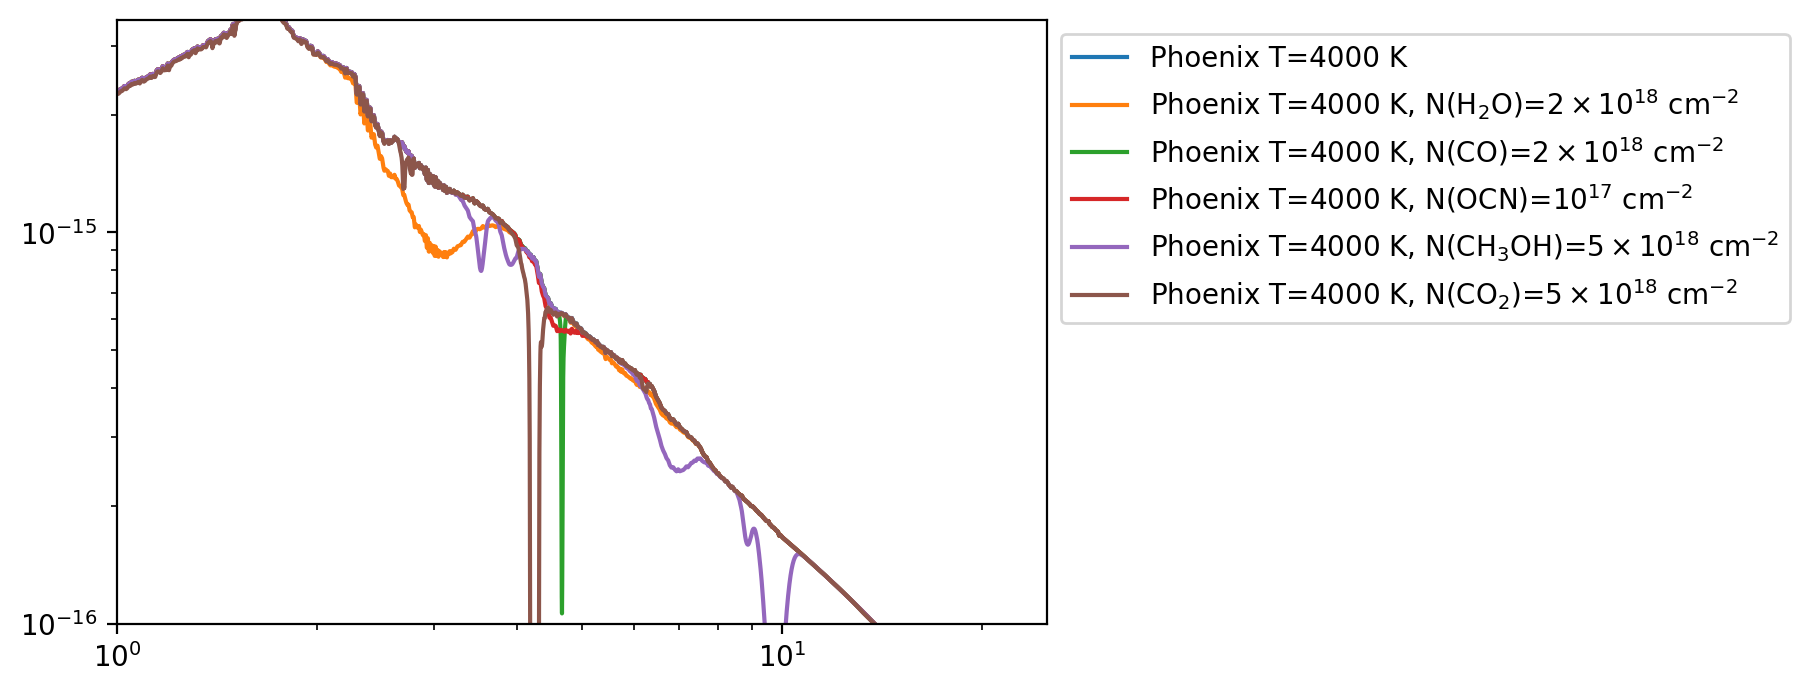

In [16]:
pl.figure(dpi=200)

pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()), phx4000['fnu'], label="Phoenix T=4000 K")
pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()),
          absorbed_spectrum(2e18*u.cm**-2, water_ice_centers, water_ice_widths, water_ice_bandstrengths),
          label="Phoenix T=4000 K, N(H$_2$O)=$2 \\times 10^{18}$ cm$^{-2}$")
pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()),
          absorbed_spectrum(2e18*u.cm**-2, co_ice_centers, co_ice_widths, co_ice_bandstrengths),
          label="Phoenix T=4000 K, N(CO)=$2 \\times 10^{18}$ cm$^{-2}$")
pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()),
          absorbed_spectrum(2e17*u.cm**-2, ocn_center, ocn_width, ocn_bandstrength),
          label="Phoenix T=4000 K, N(OCN)=10$^{17}$ cm$^{-2}$")
pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()),
          absorbed_spectrum(5e18*u.cm**-2, methanol_ice_centers, methanol_ice_widths, methanol_ice_bandstrengths),
          label="Phoenix T=4000 K, N(CH$_3$OH)=$5\\times10^{18}$ cm$^{-2}$")
pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()),
          absorbed_spectrum2(5e18*u.cm**-2, co2_consts),
          label="Phoenix T=4000 K, N(CO$_2$)=$5\\times10^{18}$ cm$^{-2}$")


pl.legend(bbox_to_anchor=[1,1])
pl.ylim(1e-16, 3.5e-15)
pl.xlim(1.0, 25)

(1.0, 25)

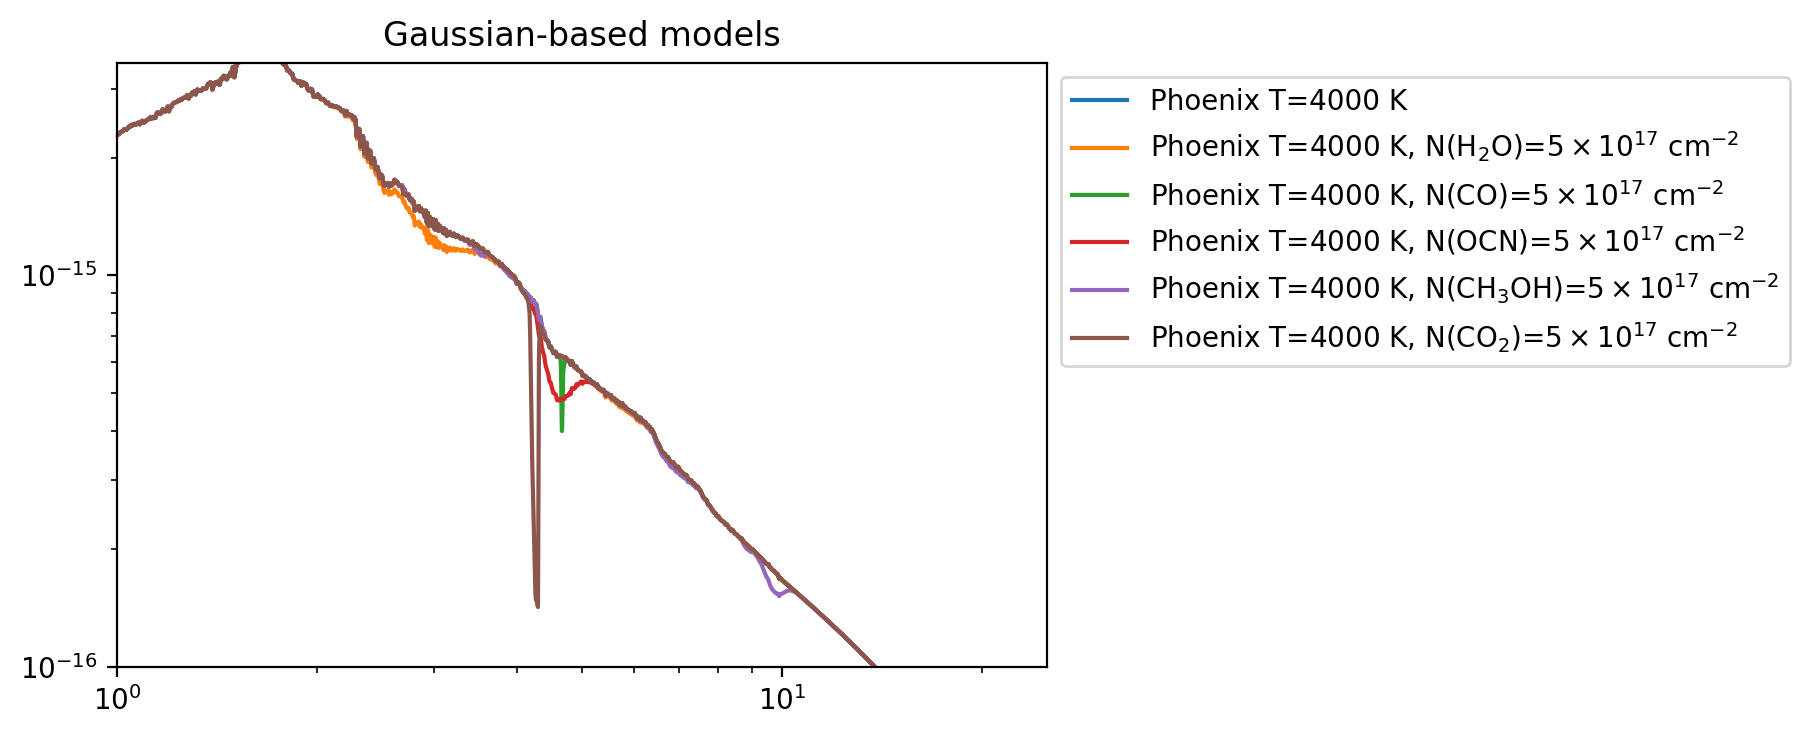

In [17]:
pl.figure(dpi=200)

pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()), phx4000['fnu'], label="Phoenix T=4000 K")
pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()),
          absorbed_spectrum(5e17*u.cm**-2, water_ice_centers, water_ice_widths, water_ice_bandstrengths),
          label="Phoenix T=4000 K, N(H$_2$O)=$5 \\times 10^{17}$ cm$^{-2}$")
pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()),
          absorbed_spectrum(5e17*u.cm**-2, co_ice_centers, co_ice_widths, co_ice_bandstrengths),
          label="Phoenix T=4000 K, N(CO)=$5 \\times 10^{17}$ cm$^{-2}$")
pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()),
          absorbed_spectrum(5e17*u.cm**-2, ocn_center, ocn_width, ocn_bandstrength),
          label="Phoenix T=4000 K, N(OCN)=$5 \\times 10^{17}$ cm$^{-2}$")
pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()),
          absorbed_spectrum(5e17*u.cm**-2, methanol_ice_centers, methanol_ice_widths, methanol_ice_bandstrengths),
          label="Phoenix T=4000 K, N(CH$_3$OH)=$5\\times10^{17}$ cm$^{-2}$")
pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()),
          absorbed_spectrum2(5e17*u.cm**-2, co2_consts),
          label="Phoenix T=4000 K, N(CO$_2$)=$5\\times10^{17}$ cm$^{-2}$")

pl.title("Gaussian-based models")
pl.legend(bbox_to_anchor=[1,1])
pl.ylim(1e-16, 3.5e-15)
pl.xlim(1.0, 25)

(1.0, 25)

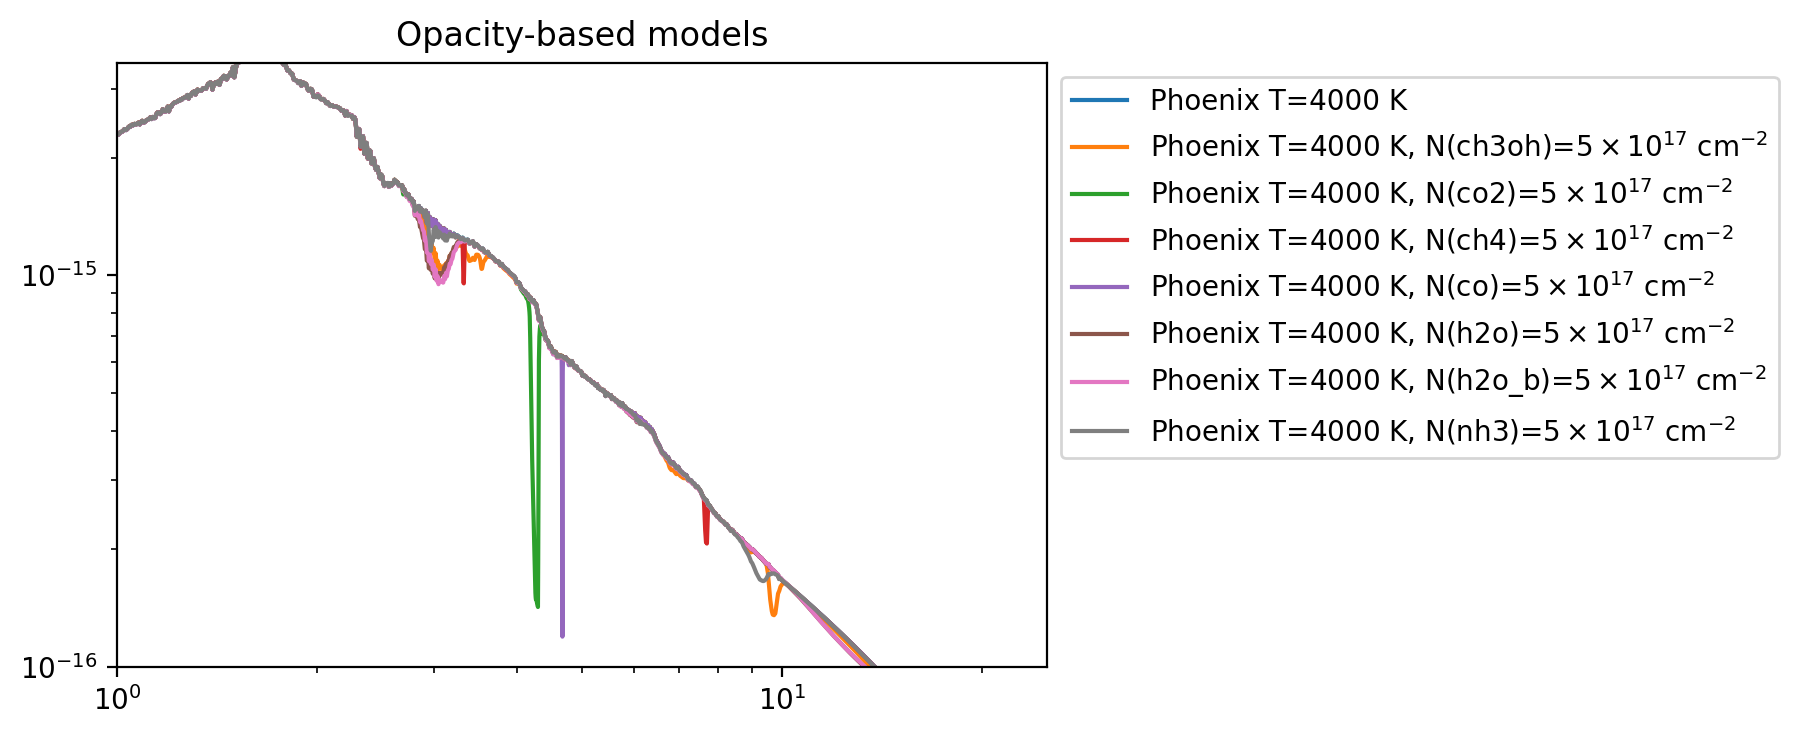

In [18]:
pl.figure(dpi=200)
pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()), phx4000['fnu'], label="Phoenix T=4000 K")

for molecule, md in molecule_data.items():
    #print(molecule, md)
    consts = load_molecule(molecule)
    spec = absorbed_spectrum2(5e17*u.cm**-2, consts, molecular_weight=md['molwt'])
    pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()),
              spec,
              label=f"Phoenix T=4000 K, N({molecule})=$5\\times10^{{17}}$ cm$^{{-2}}$")
pl.title("Opacity-based models")

pl.legend(bbox_to_anchor=[1.0, 1.0])
pl.ylim(1e-16, 3.5e-15)
pl.xlim(1.0, 25)

(1.0, 25)

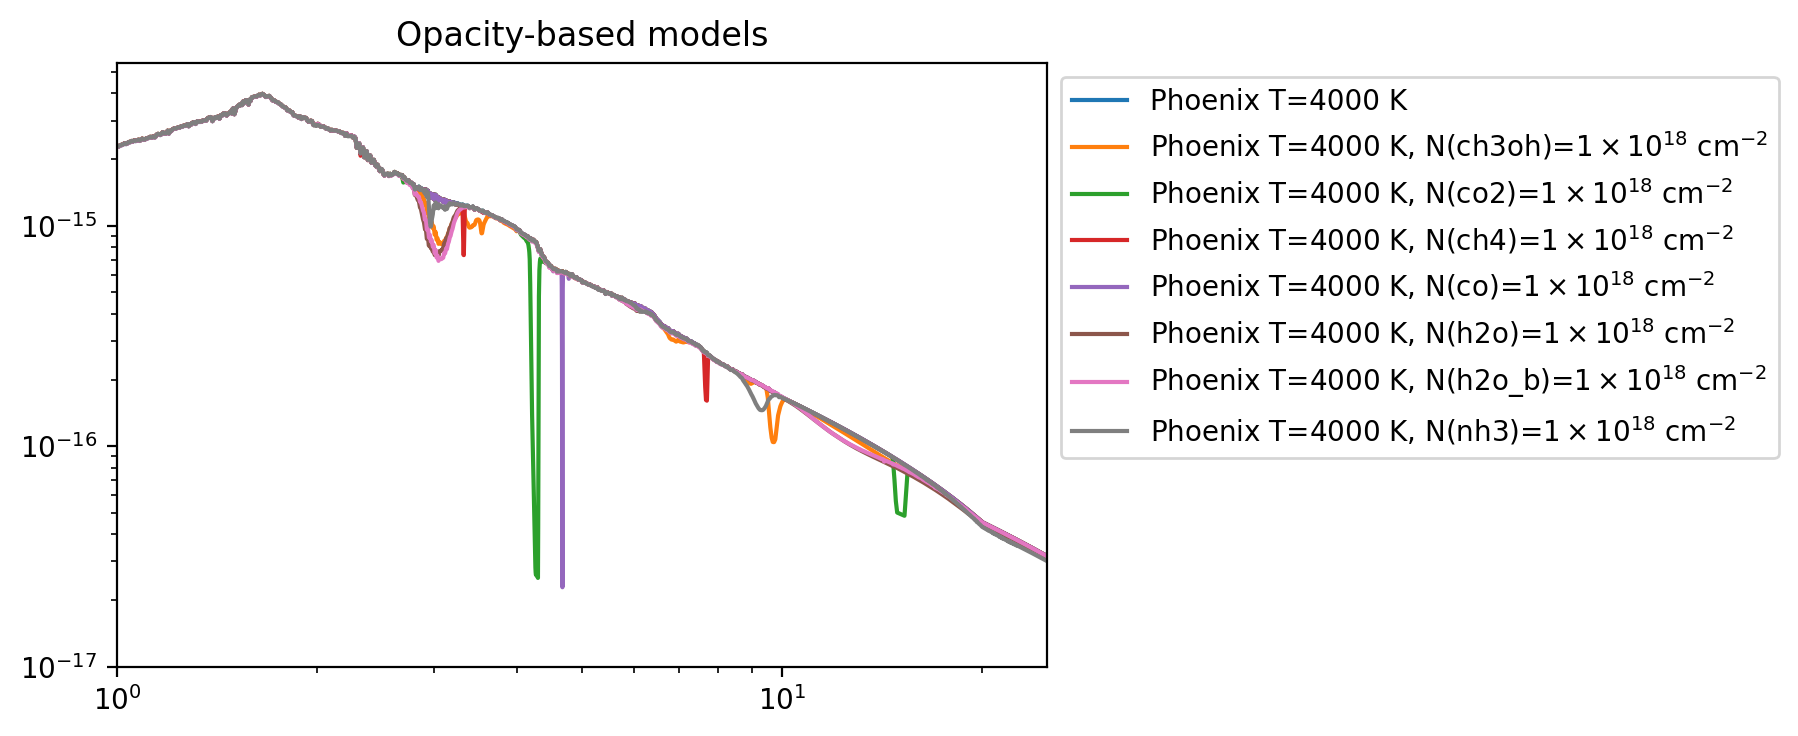

In [19]:
pl.figure(dpi=200)
pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()), phx4000['fnu'], label="Phoenix T=4000 K")

for molecule, md in molecule_data.items():
    #print(molecule, md)
    consts = load_molecule(molecule)
    spec = absorbed_spectrum2(1e18*u.cm**-2, consts, molecular_weight=md['molwt'])
    pl.loglog(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()),
              spec,
              label=f"Phoenix T=4000 K, N({molecule})=$1\\times10^{{18}}$ cm$^{{-2}}$")
pl.title("Opacity-based models")

pl.legend(bbox_to_anchor=[1.0, 1.0])
pl.ylim(1e-17, 5.5e-15)
pl.xlim(1.0, 25)

In [20]:
from astroquery.svo_fps import SvoFps

def convsum(xarr, model_data, filter_table, doplot=False):
    filtwav = u.Quantity(filter_table['Wavelength'], u.AA).to(u.um)

    inds = np.argsort(xarr.to(u.um))

    interpd = np.interp(filtwav,
                        xarr.to(u.um)[inds],
                        model_data[inds])
    #print(interpd, model_data, filter_table['Transmission'])
    #print(interpd.max(), model_data.max(), filter_table['Transmission'].max())
    result = (interpd * filter_table['Transmission'].value)
    if doplot:
        L, =pl.plot(filtwav, filter_table['Transmission'])
        pl.plot(filtwav, result, color=L.get_color())
        pl.plot(filtwav, interpd, color=L.get_color())
    # looking for average flux over the filter
    result = result.sum() / filter_table['Transmission'].sum()
    #dnu = np.abs(xarr[1].to(u.Hz, u.spectral()) - xarr[0].to(u.Hz, u.spectral()))
    return result# * dnu

def fluxes_in_filters(xarr, modeldata, doplot=False):
    telescope = 'JWST'

    if doplot:
        pl.loglog(xarr.to(u.um), modeldata)
        pl.xlabel("Wavelengh [$\\mu$m]")
        pl.ylabel("Flux [Jy]")
    
    fluxes = {}
    for instrument in ('NIRCam', 'MIRI'):
        filterlist = SvoFps.get_filter_list(telescope, instrument)
        filterids = filterlist['filterID']
        fluxes_ = {fid: convsum(xarr, modeldata, SvoFps.get_transmission_data(fid), doplot=doplot)
                  for fid in list(filterids)}
        fluxes.update(fluxes_)
    return fluxes

In [21]:
print("TODO: check why the values are coming out weird.  Probably a unit mismatch.")
rslt = fluxes_in_filters(u.Quantity(phx4000['nu'], u.Hz).to(u.um, u.spectral()), u.Quantity(phx4000['fnu'], u.Jy))
rslt

TODO: check why the values are coming out weird.  Probably a unit mismatch.


{'JWST/NIRCam.F070W': <Quantity 2.29587934e+08 Jy>,
 'JWST/NIRCam.F090W': <Quantity 2.2960245e+08 Jy>,
 'JWST/NIRCam.F115W': <Quantity 2.61106256e+08 Jy>,
 'JWST/NIRCam.F140M': <Quantity 3.10872804e+08 Jy>,
 'JWST/NIRCam.F150W': <Quantity 3.43760882e+08 Jy>,
 'JWST/NIRCam.F162M': <Quantity 3.80852568e+08 Jy>,
 'JWST/NIRCam.F164N': <Quantity 3.93168675e+08 Jy>,
 'JWST/NIRCam.F150W2': <Quantity 3.02468473e+08 Jy>,
 'JWST/NIRCam.F182M': <Quantity 3.26629854e+08 Jy>,
 'JWST/NIRCam.F187N': <Quantity 3.12537457e+08 Jy>,
 'JWST/NIRCam.F200W': <Quantity 2.95168509e+08 Jy>,
 'JWST/NIRCam.F210M': <Quantity 2.74638463e+08 Jy>,
 'JWST/NIRCam.F212N': <Quantity 2.70768455e+08 Jy>,
 'JWST/NIRCam.F250M': <Quantity 1.80069139e+08 Jy>,
 'JWST/NIRCam.F277W': <Quantity 1.57024795e+08 Jy>,
 'JWST/NIRCam.F300M': <Quantity 1.37257131e+08 Jy>,
 'JWST/NIRCam.F323N': <Quantity 1.26258135e+08 Jy>,
 'JWST/NIRCam.F322W2': <Quantity 1.30407307e+08 Jy>,
 'JWST/NIRCam.F335M': <Quantity 1.22567458e+08 Jy>,
 'JWST/NIRC

In [22]:
cmds = [(('JWST/NIRCam.F182M', 'JWST/NIRCam.F212N'),
         ('JWST/NIRCam.F115W', 'JWST/NIRCam.F200W')),
        (('JWST/NIRCam.F300M', 'JWST/NIRCam.F356W'),
         ('JWST/NIRCam.F466N', 'JWST/NIRCam.F444W')),
        (('JWST/MIRI.F560W', 'JWST/MIRI.F770W'),
         ('JWST/MIRI.F1000W', 'JWST/MIRI.F1130W')),
        (('JWST/MIRI.F1280W', 'JWST/MIRI.F1500W'),
         ('JWST/MIRI.F1800W', 'JWST/MIRI.F2100W')),
       ]

In [23]:
#mods = {'phx4000': fluxes_in_filters(u.Quantity(phx4000['nu'],u.Hz).to(u.um, u.spectral()), u.Quantity(phx4000['fnu'], u.Jy)),
#        'phx4000ocn': fluxes_in_filters(u.Quantity(phx4000['nu'],u.Hz).to(u.um, u.spectral()) , absorbed_spectrum(2e17*u.cm**-2, ocn_center, ocn_width, ocn_bandstrength, spectrum=u.Quantity(phx4000['fnu'], *u.Jy)),
#        'phx4000co': fluxes_in_filters(u.Quantity(phx4000['nu'],u.Hz).to(u.um, u.spectral()) , absorbed_spectrum(2e18*u.cm**-2, co_ice_centers, co_ice_widths, co_ice_bandstrengths, spectrum=u.Quantity(phx4000['fnu'], *u.Jy)),
#        'phx4000h2o': fluxes_in_filters(u.Quantity(phx4000['nu'],u.Hz).to(u.um, u.spectral()) , absorbed_spectrum(2e18*u.cm**-2, water_ice_centers, water_ice_widths, water_ice_bandstrengths, spectrum=u.Quantity(phx4000['fnu'], *u.Jy)),
#        'phx4000ch3oh': fluxes_in_filters(u.Quantity(phx4000['nu'],u.Hz).to(u.um, u.spectral()) , absorbed_spectrum(5e18*u.cm**-2, methanol_ice_centers, methanol_ice_widths, methanol_ice_bandstrengths, spectrum=u.Quantity(phx4000['fnu'], *u.Jy)),
#       }

In [24]:
import matplotlib

In [25]:
temperatures = (2000, 3000, 4000, 5000, 7000, 10000)

tmods = {temperature: atmo_model(temperature)
         for temperature in temperatures}

In [ ]:
pl.figure(figsize=(12, 12), dpi=125)
#xarr = u.Quantity(phx4000['nu'],u.Hz).to(u.um, u.spectral())


with matplotlib.rc_context({'font.size': 16}):
    for ii, (cmd_x, cmd_y) in enumerate(cmds):
        ax = pl.subplot(2, 2, ii+1)
        ax.set_xlabel(f'[{cmd_x[0][-5:]}] - [{cmd_x[1][-5:]}]')
        ax.set_ylabel(f'[{cmd_y[0][-5:]}] - [{cmd_y[1][-5:]}]')

        
        for molecule, moldata in molecule_data.items():
            consts = load_molecule(molecule)
            xdata = []
            ydata = []
            for temperature in (2000, 3000, 4000, 5000, 7000, 10000):
                xarr = tmods[temperature]['nu'].quantity.to(u.um, u.spectral())
                spec = absorbed_spectrum2(1e18*u.cm**-2, consts, molecular_weight=md['molwt'],
                                          spectrum=tmods[temperature]['fnu'].quantity,
                                          xarr=xarr,
                                         )

                flxd = fluxes_in_filters(xarr, spec)
                mags_x = flxd[cmd_x[0]].to(u.ABmag), flxd[cmd_x[1]].to(u.ABmag)
                mags_y = flxd[cmd_y[0]].to(u.ABmag), flxd[cmd_y[1]].to(u.ABmag)
                xdata.append(mags_x[0]-mags_x[1])
                ydata.append(mags_y[0]-mags_y[1])
            #ax.scatter(xdata, ydata, color=pl.cm.jet(temperatures), label=molecule)
            ax.plot(xdata, ydata, label=molecule, marker='o')

        xdata = []
        ydata = []
        for temperature in (2000, 3000, 4000, 5000, 7000, 10000):
            xarr = tmods[temperature]['nu'].quantity.to(u.um, u.spectral())
            flxd = fluxes_in_filters(xarr, tmods[temperature]['fnu'].quantity)
            mags_x = flxd[cmd_x[0]].to(u.ABmag), flxd[cmd_x[1]].to(u.ABmag)
            mags_y = flxd[cmd_y[0]].to(u.ABmag), flxd[cmd_y[1]].to(u.ABmag)
            xdata.append(mags_x[0]-mags_x[1])
            ydata.append(mags_y[0]-mags_y[1])
        ax.plot(xdata, ydata, label='No Ice', color='k')        

        pl.legend(loc='best')
pl.tight_layout()